# Import data and variables

In [1]:
# import python module

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

from tqdm import tqdm
from scipy.fftpack import fft, ifft, fft2, ifft2, fftfreq, fftshift, ifftshift
from sklearn.metrics import r2_score

In [2]:
# import data file

input_file = 'WireCut2_1.csv'
x_or_y = 'y'                              # data direction for 1D extraction (type 'x' or 'y')
row_no = 10                              # row no. for 1D data extraction

In [3]:
# assign constant

## smoothing Gaussian filter
lambda_s = 30                             # micro-m
freq_s = 1/lambda_s                       # (micro-m)^-1

## cut-off Gaussian filter
lambda_c = 450                            # micro-m
freq_c = 1/lambda_c                       # (micro-m)^-1

## dominant freq
ratio_amp_dom2max_1D = 10                 # %
accept_dom_rSqua_2D = 0.90                  # value from 0 to 1
                                            ## 0 = estimated data 'poorly' fit the reference data
                                            ## 1 = estimated data 'well' fit the reference data

#------------------------------------------------------------------------------------------------------#            
            
## constant for gaussian filter (do not touch)
alfa = 0.4697
beta = 0.2206

In [4]:
# to trim non-related area of data
# ex. processed surface (drill, mill), the interested height is only one part of the measured surface

trim_command = 'y'                        # 'y' if trim, 'n' if not-trim
trim_min = 500                            # mm
trim_max = 1000                            # mm

In [5]:
# to assign length of dominant surface output (.csv)
# cut one corner of the area 

assign_csv_len = 'n'                      # 'y' if assign, 'n' if not-assign
csv_len_1D = 50
csv_len_2D = 50

In [6]:
# assign no. of point for surface reconstruction
## for waviness ##

data_pnts_recon = 21
elemsize_recon = 500
data_list_recon = np.linspace(0, elemsize_recon, data_pnts_recon)     # numpy.linspace(start, stop, num)
data_len_recon = data_list_recon[-1]
data_interval_recon = data_list_recon[1] - data_list_recon[0]
axis_dist_recon = (0, data_len_recon, 0, data_len_recon)

In [7]:
# # assign no. of point for surface reconstruction
# ## for roughness ##

# data_pnts_recon = 251
# elemsize_recon = 500
# data_list_recon = np.linspace(0, elemsize_recon, data_pnts_recon)     # numpy.linspace(start, stop, num)
# data_len_recon = data_list_recon[-1]
# data_interval_recon = data_list_recon[1] - data_list_recon[0]
# axis_dist_recon = (0, data_len_recon, 0, data_len_recon)

In [8]:
print(data_list_recon)
print(data_interval_recon)

[  0.  25.  50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325.
 350. 375. 400. 425. 450. 475. 500.]
25.0


# Data pre-processing

## Data trimming

In [9]:
# import data
df = pd.read_csv(input_file, usecols=['# X','Y','Z'], skiprows=6)
df = df.rename(index=str, columns={"# X": "X"})

df.head()

,X,Y,Z
0,0.0000,0.0,-0.00031
1,1.5625,0.0,-0.00031
2,3.1250,0.0,-0.00031
3,4.6875,0.0,-0.00031
4,6.2500,0.0,-0.00031


In [10]:
# trim input data to be square

x_list = sorted(list(set(df['X'])))
y_list = sorted(list(set(df['Y'])))

x_pnts = len(x_list)
y_pnts = len(y_list)
data_pnts = min(x_pnts, y_pnts)


# no of data point after cut = even

if data_pnts % 2 != 0:
    data_pnts = data_pnts - 1
    
data_list = x_list[0:data_pnts]
data_len = data_list[-1]
    
    
print(x_pnts)
print(y_pnts)
print(data_pnts)

931
932
930


In [11]:
# pivot table

df_raw = df.pivot_table(values='Z', index='Y', columns='X', aggfunc='first')
df_raw = df_raw.iloc[0:data_pnts, 0:data_pnts]

df_raw.iloc[0:5,0:5]

X,0.0,1.5625,3.125,4.6875,6.25
Y,,,,,
0.0000,-0.00031,-0.00031,-0.00031,-0.00031,-0.00031
1.5625,-0.00031,-0.00031,-0.00031,-0.00031,-0.00031
3.1250,-0.00031,-0.00031,-0.00031,-0.00031,-0.00031
4.6875,-0.00031,-0.00031,-0.00031,-0.00031,-0.00031
6.2500,-0.00031,-0.00031,-0.00031,-0.00031,-0.00031


In [12]:
# find index of trim_min, trim_max

if trim_command == 'y':

    trim_min_loc = 0
    trim_max_loc = 0

    for i in range(len(data_list)):
        if data_list[i] > trim_min:
            trim_min_loc = i
            break

    for i in range(len(data_list)):
        if data_list[len(data_list)-1-i] < trim_max:
            trim_max_loc = len(data_list)-1-i
            break
    
    if (trim_max_loc - trim_min_loc) % 2 != 0:               # no of data point after cut = even
        trim_min_loc = trim_min_loc + 1

In [13]:
# pivot table

if trim_command == 'y':
    df_2D = df.pivot_table(values='Z', index='Y', columns='X', aggfunc='first')
    df_2D = df_2D.iloc[trim_min_loc:trim_max_loc, trim_min_loc:trim_max_loc]

    df_2D.iloc[0:5,0:5]

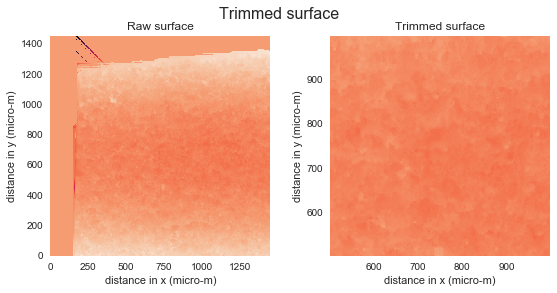

In [14]:
# plot trimmed surface

if trim_command == 'y':

    # set axis
    axis_dist_raw = (0, data_len, 0, data_len)                                          
    axis_dist_2D = (data_list[trim_min_loc], data_list[trim_max_loc], data_list[trim_min_loc], data_list[trim_max_loc])                                         
    v_min_raw = np.amin(df_raw.values)
    v_max_raw = np.amax(df_raw.values)


    plot_size = (8, 4)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
    f.suptitle("Trimmed surface", fontsize=16)

    ax1.imshow(df_raw, extent=axis_dist_raw, vmin=v_min_raw, vmax=v_max_raw)
    ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax1.title.set_text('Raw surface')
    ax1.grid(False)

    ax2.imshow(df_2D, extent=axis_dist_2D, vmin=v_min_raw, vmax=v_max_raw) 
    ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax2.title.set_text('Trimmed surface')
    ax2.grid(False)

    plt.tight_layout()
    f.subplots_adjust(top=0.88)

In [15]:
# assign spatial axis

if trim_command == 'y':
    
    data_list = x_list[0:trim_max_loc-trim_min_loc]
    data_len = data_list[-1]
    data_pnts = len(data_list)

    print(trim_min_loc)
    print(trim_max_loc)
    print(data_pnts)

321
639
318


In [16]:
if trim_command == 'n':
    df_2D = df_raw.copy()

## Axis assigns

In [17]:
# show spatial axis

print(data_list[0:5], "...", data_list[-5:])
print(data_len)
print(data_pnts)

[0.0, 1.5625, 3.125, 4.6875, 6.25] ... [489.06199999999995, 490.625, 492.18699999999995, 493.75, 495.31199999999995]
495.31199999999995
318


In [18]:
# sampling info

samp_space = data_list[1] - data_list[0]             # micro-m
samp_rate = 1/samp_space                             # (micro-m)^(-1)

print(samp_space)
print(samp_rate)

1.5625
0.64


In [19]:
# assign freq axis

freq_full = fftfreq(data_pnts, samp_space)
freq_full_shift = fftshift(freq_full)
freq_half = freq_full_shift[freq_full_shift >= 0]

print(freq_full[0:5], "...", freq_full[-5:])
print(freq_full_shift[0:5], "...", freq_full_shift[-5:])
print(freq_half[0:5], "...", freq_half[-5:])

[0.         0.00201258 0.00402516 0.00603774 0.00805031] ... [-0.01006289 -0.00805031 -0.00603774 -0.00402516 -0.00201258]
[-0.32       -0.31798742 -0.31597484 -0.31396226 -0.31194969] ... [0.30993711 0.31194969 0.31396226 0.31597484 0.31798742]
[0.         0.00201258 0.00402516 0.00603774 0.00805031] ... [0.30993711 0.31194969 0.31396226 0.31597484 0.31798742]


## Extract row of data (1D)

In [20]:
# check selection in x or y direction
# extract out row of data

if x_or_y == 'x':
    z_data = df_2D.iloc[:, row_no].values
        
if x_or_y == 'y':
    z_data = df_2D.iloc[row_no, :].values

# Gaussian filter

## 1D-Gaussian

In [21]:
# create gaussian 1D

df_gauss_1D = pd.DataFrame(data = freq_full_shift, columns = ['freq']) 
df_gauss_1D['f_to_fc'] = df_gauss_1D['freq'] / freq_c
df_gauss_1D['low_gauss'] = np.exp(-np.pi * (alfa * df_gauss_1D['f_to_fc'])**2)
df_gauss_1D['high_gauss'] = 1 - df_gauss_1D['low_gauss']

df_gauss_1D.head()

,freq,f_to_fc,low_gauss,high_gauss
0,-0.320000,-144.000000,0.0,1.0
1,-0.317987,-143.094340,0.0,1.0
2,-0.315975,-142.188679,0.0,1.0
3,-0.313962,-141.283019,0.0,1.0
4,-0.311950,-140.377358,0.0,1.0


In [22]:
low_gauss_1D = df_gauss_1D['low_gauss'].values
high_gauss_1D = df_gauss_1D['high_gauss'].values

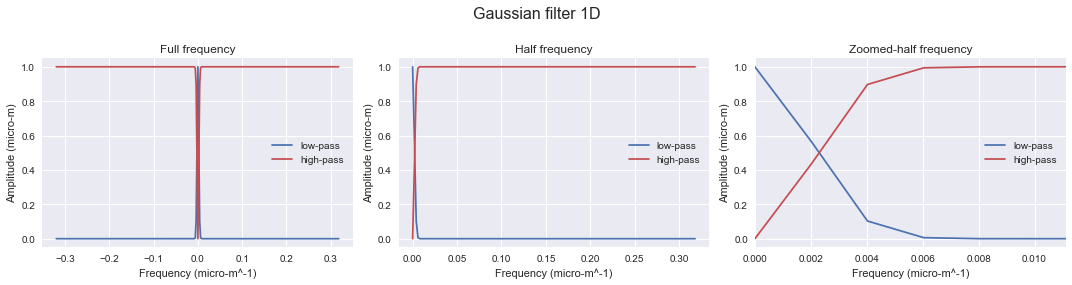

In [23]:
plot_size = (15, 4)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Gaussian filter 1D", fontsize=16)

ax1.plot(freq_full_shift, low_gauss_1D, 'b')
ax1.plot(freq_full_shift, high_gauss_1D, 'r')
ax1.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax1.title.set_text('Full frequency')
ax1.legend(('low-pass','high-pass'), loc='center right')

ax2.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
ax2.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
ax2.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax2.title.set_text('Half frequency')
ax2.legend(('low-pass','high-pass'), loc='center right')

ax3.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
ax3.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
ax3.set_xlim(0, freq_c*5)
ax3.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax3.title.set_text('Zoomed-half frequency')
ax3.legend(('low-pass','high-pass'), loc='center right')

plt.tight_layout()
f.subplots_adjust(top=0.8)

## 1D-Gaussian smoothing filter

In [24]:
# create gaussian smoothing filter 1D

df_gauss_1D['f_to_fs'] = df_gauss_1D['freq'] / freq_s
df_gauss_1D['smooth_gauss'] = np.exp(-np.pi * (alfa * df_gauss_1D['f_to_fs'])**2)

df_gauss_1D.head()

,freq,f_to_fc,low_gauss,high_gauss,f_to_fs,smooth_gauss
0,-0.320000,-144.000000,0.0,1.0,-9.600000,1.816675e-28
1,-0.317987,-143.094340,0.0,1.0,-9.539623,4.046877e-28
2,-0.315975,-142.188679,0.0,1.0,-9.479245,8.969495e-28
3,-0.313962,-141.283019,0.0,1.0,-9.418868,1.977978e-27
4,-0.311950,-140.377358,0.0,1.0,-9.358491,4.339905e-27


In [25]:
smooth_gauss_1D = df_gauss_1D['smooth_gauss'].values

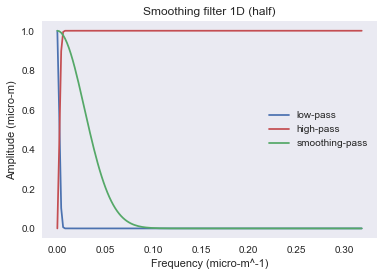

In [26]:
plt.title('Smoothing filter 1D (half)')

plt.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
plt.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
plt.plot(freq_half, smooth_gauss_1D[data_pnts//2:], 'g')

plt.ylabel('Amplitude (micro-m)')
plt.xlabel('Frequency (micro-m^-1)')
plt.legend(('low-pass','high-pass','smoothing-pass'), loc='center right')

plt.grid()
plt.show()

## 2D-Gaussian

In [27]:
# prepare fx/fc and fy/fc to put in equation

df_fx = pd.DataFrame(np.zeros((data_pnts, data_pnts)))

for i in range(data_pnts):
    df_fx.iloc[i,:] = freq_full_shift                             # row by rows
    

df_fy = pd.DataFrame(np.zeros((data_pnts, data_pnts)))

for i in range(data_pnts):
    df_fy.iloc[:,i] = freq_full_shift                             # column by columns


df_fx2fc = df_fx.copy() / freq_c
df_fy2fc = df_fy.copy() / freq_c

In [28]:
# input fx/fc and fy/fc to compute Gaussian

df_low_gauss = np.exp(-np.pi * beta * (df_fx2fc.pow(2) + df_fy2fc.pow(2)))
df_high_gauss = 1 - df_low_gauss

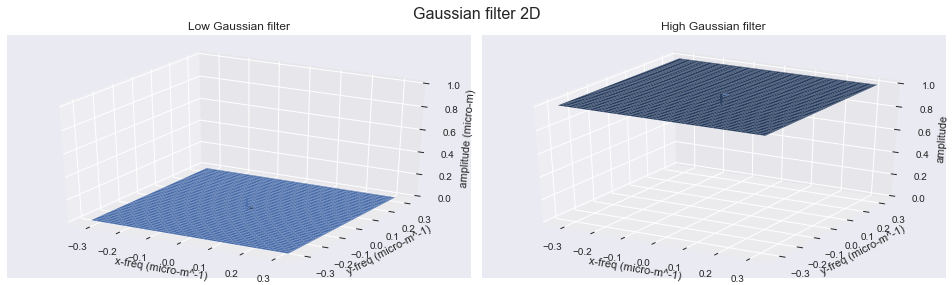

In [29]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Gaussian filter 2D', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_low_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Low Gaussian filter')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_high_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude')
ax.title.set_text('High Gaussian filter')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## 2D-Gaussian smoothing filter

In [30]:
# prepare fx/fc and fy/fc to put in equation

df_fx2fs = df_fx.copy() / freq_s
df_fy2fs = df_fy.copy() / freq_s

In [31]:
# input fx/fc and fy/fc to compute Gaussian

df_smooth_gauss = np.exp(-np.pi * beta * (df_fx2fs.pow(2) + df_fy2fs.pow(2)))

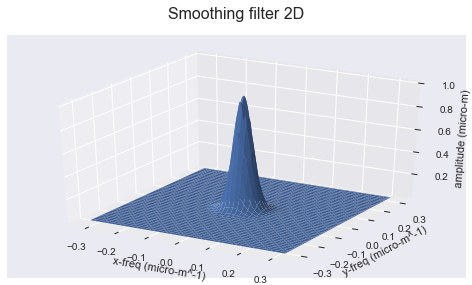

In [32]:
fig = plt.figure(figsize=plt.figaspect(0.6))
fig.suptitle('Smoothing filter 2D', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_smooth_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# Surface transformation

## 1D-data

### Fourier transform

In [33]:
z_fou_1D = fft(z_data) 
z_inv_1D = ifft(z_fou_1D)

In [34]:
# shift freq domain to multiply with Gaussian

z_fou_1D_shift = fftshift(z_fou_1D)


# amplitude of z-fourier

z_fou_1D_full = 1/data_pnts * abs(z_fou_1D_shift)
z_fou_1D_half = 2/data_pnts * abs(z_fou_1D[0:data_pnts//2])    # fourier amplitude correction
                                                               # [0:data_pnts//2] : to cut only positive half of freq
                                                               # abs() : to get magnitude
                                                               # /data_pnts : to normalized operation of FFT summation
                                                               # *2 : to supplement value of f negative to f positive

In [35]:
# set limit for graph plot (1D)

plt_dist_xlim_1D = data_len
plt_dist_zlim_1D = max(np.amax(z_data), abs(np.amin(z_data))) * 1.3
plt_freq_xlim_1D = samp_rate
plt_freq_zlim_1D = np.amax(z_fou_1D_half) * 1.3

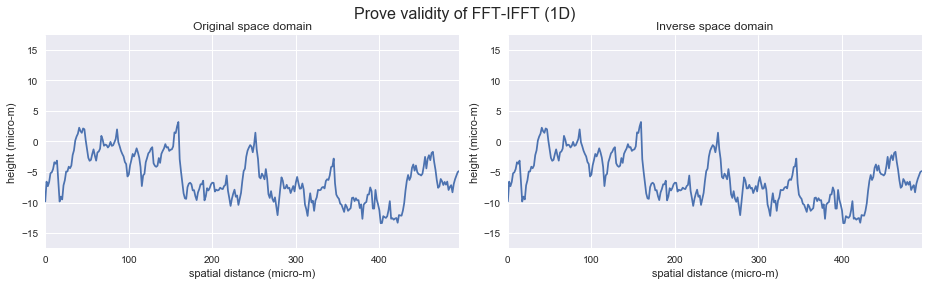

In [36]:
# prove validity of Fourier transform after cut outlier

plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Prove validity of FFT-IFFT (1D)", fontsize=16)

ax1.plot(data_list, z_data)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Original space domain')

ax2.plot(data_list, z_inv_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Inverse space domain')

plt.tight_layout()
f.subplots_adjust(top=0.88)

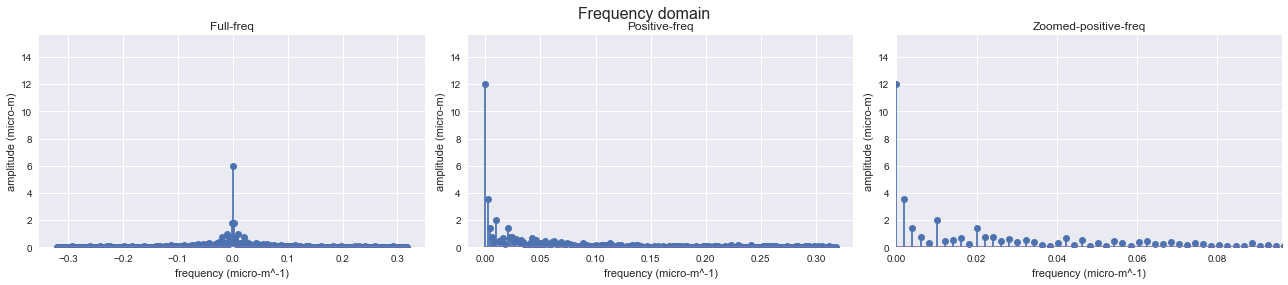

In [37]:
# plot freq domain

plot_size = (18, 4)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Frequency domain", fontsize=16)

ax1.stem(freq_full_shift, z_fou_1D_full)
ax1.set_ylim(0, plt_freq_zlim_1D)
ax1.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax1.title.set_text('Full-freq')

ax2.stem(freq_half, z_fou_1D_half)
ax2.set_ylim(0, plt_freq_zlim_1D)
ax2.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax2.title.set_text('Positive-freq')

ax3.stem(freq_half, z_fou_1D_half)
ax3.set_xlim(0, plt_freq_xlim_1D * 0.15)
ax3.set_ylim(0, plt_freq_zlim_1D)
ax3.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax3.title.set_text('Zoomed-positive-freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [38]:
# compare result

rSq_fft_1D = r2_score(z_data, z_inv_1D.real)

print('Prove validity of Fourier transform 1D')
print('R-square: ', rSq_fft_1D)

Prove validity of Fourier transform 1D
R-square:  1.0


### Smoothing filter

In [39]:
# assign dataframe for operation

df_conv_1D = pd.DataFrame(data=freq_full_shift, columns=['freq'])
df_conv_1D['z_fou'] = z_fou_1D_shift
df_conv_1D['low_gauss'] = low_gauss_1D
df_conv_1D['high_gauss'] = high_gauss_1D
df_conv_1D['smooth_gauss'] = smooth_gauss_1D

In [40]:
df_conv_1D['smooth_conv'] = df_conv_1D['z_fou'] * df_conv_1D['smooth_gauss']

df_conv_1D.head()

,freq,z_fou,low_gauss,high_gauss,smooth_gauss,smooth_conv
0,-0.320000,(-16.415474900000163+0j),0.0,1.0,1.816675e-28,(-2.9821589913686046e-27+0j)
1,-0.317987,(8.603220964711767+2.90491224619916j),0.0,1.0,4.046877e-28,(3.4816173039746715e-27+1.1755821202755505e-27j)
2,-0.315975,(-7.6398912062327575+1.9569797737647576j),0.0,1.0,8.969495e-28,(-6.85259635044077e-27+1.755311966307367e-27j)
3,-0.313962,(-3.1982486760868483-1.7178935340445776j),0.0,1.0,1.977978e-27,(-6.326064801694283e-27-3.39795523094668e-27j)
4,-0.311950,(-4.572919055988789-11.566026295644704j),0.0,1.0,4.339905e-27,(-1.9846035422261322e-26-5.0195458250580816e-26j)


In [41]:
# shift freq domain back for IFFT operation

z_fou_1D_ishift = ifftshift(df_conv_1D['z_fou'].values)
z_fou_smooth_1D_ishift = ifftshift(df_conv_1D['smooth_conv'].values)

In [42]:
# correct freq amplitude for graph plot

z_fou_smooth_1D_full = 1/data_pnts * abs(z_fou_smooth_1D_ishift)
z_fou_smooth_1D_half = 2/data_pnts * abs(z_fou_smooth_1D_ishift[0:data_pnts//2])

In [43]:
# inverse Fourier transform

z_inv_1D = ifft(z_fou_1D_ishift)
z_inv_smooth_1D = ifft(z_fou_smooth_1D_ishift)

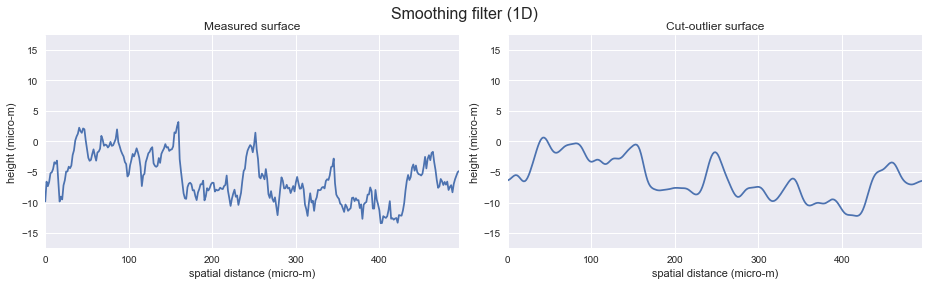

In [44]:
plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Smoothing filter (1D)", fontsize=16)

ax1.plot(data_list, z_data)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Measured surface')

ax2.plot(data_list, z_inv_smooth_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Cut-outlier surface')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [45]:
# compare result

rSq_ori_corr_1D = r2_score(z_data, z_inv_smooth_1D.real)

print('Original to cut-outlier surface')
print('R-square: ', rSq_ori_corr_1D)

Original to cut-outlier surface
R-square:  0.8904252535223438


### Waviness-Roughness filter

In [46]:
# convolution by mulplication in freq domain

df_conv_1D['low_conv'] = df_conv_1D['smooth_conv'] * df_conv_1D['low_gauss']
df_conv_1D['high_conv'] = df_conv_1D['smooth_conv'] * df_conv_1D['high_gauss']

df_conv_1D.head()

,freq,z_fou,low_gauss,high_gauss,smooth_gauss,smooth_conv,low_conv,high_conv
0,-0.320000,(-16.415474900000163+0j),0.0,1.0,1.816675e-28,(-2.9821589913686046e-27+0j),(-0+0j),(-2.9821589913686046e-27+0j)
1,-0.317987,(8.603220964711767+2.90491224619916j),0.0,1.0,4.046877e-28,(3.4816173039746715e-27+1.1755821202755505e-27j),0j,(3.4816173039746715e-27+1.1755821202755505e-27j)
2,-0.315975,(-7.6398912062327575+1.9569797737647576j),0.0,1.0,8.969495e-28,(-6.85259635044077e-27+1.755311966307367e-27j),(-0+0j),(-6.85259635044077e-27+1.755311966307367e-27j)
3,-0.313962,(-3.1982486760868483-1.7178935340445776j),0.0,1.0,1.977978e-27,(-6.326064801694283e-27-3.39795523094668e-27j),-0j,(-6.326064801694283e-27-3.39795523094668e-27j)
4,-0.311950,(-4.572919055988789-11.566026295644704j),0.0,1.0,4.339905e-27,(-1.9846035422261322e-26-5.0195458250580816e-26j),-0j,(-1.9846035422261322e-26-5.0195458250580816e-26j)


In [47]:
# shift freq domain back for IFFT operation

z_fou_low_1D_ishift = ifftshift(df_conv_1D['low_conv'].values)
z_fou_high_1D_ishift = ifftshift(df_conv_1D['high_conv'].values)

In [48]:
# correct freq amplitude for graph plot

z_fou_low_1D_full = 1/data_pnts * abs(z_fou_low_1D_ishift)
z_fou_low_1D_half = 2/data_pnts * abs(z_fou_low_1D_ishift[0:data_pnts//2])

z_fou_high_1D_full = 1/data_pnts * abs(z_fou_high_1D_ishift)
z_fou_high_1D_half = 2/data_pnts * abs(z_fou_high_1D_ishift[0:data_pnts//2])

In [49]:
# inverse Fourier transform

z_inv_low_1D = ifft(z_fou_low_1D_ishift)
z_inv_high_1D = ifft(z_fou_high_1D_ishift)

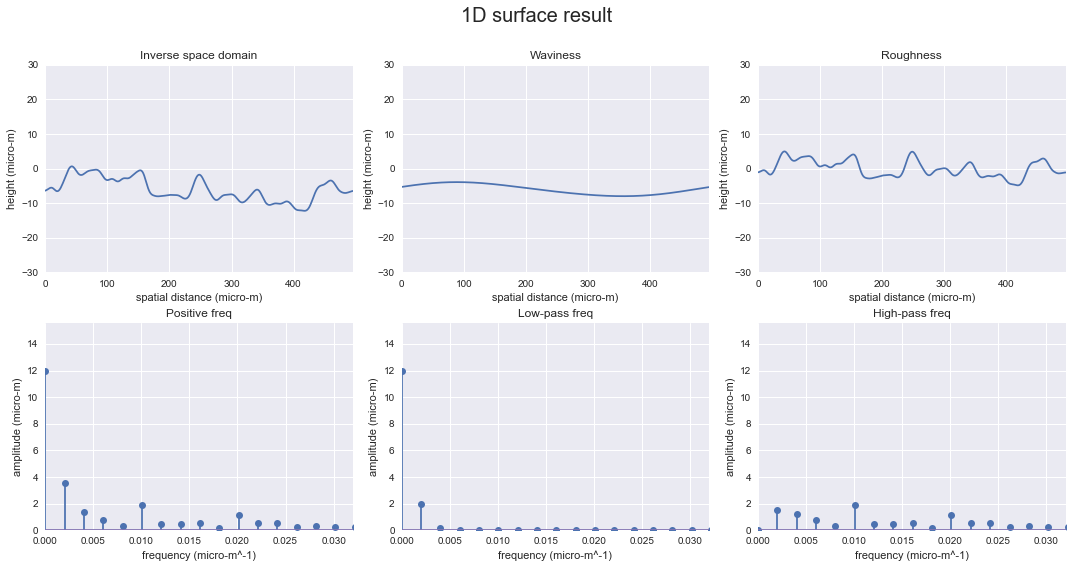

In [50]:
plot_size = (15, 8)
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
f.suptitle("1D surface result", fontsize=20)

ax1.plot(data_list, z_inv_smooth_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-30, 30)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Inverse space domain')

ax2.plot(data_list, z_inv_low_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-30, 30)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Waviness')

ax3.plot(data_list, z_inv_high_1D.real)
ax3.set_xlim(0, plt_dist_xlim_1D)
ax3.set_ylim(-30, 30)
ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax3.title.set_text('Roughness')

ax4.stem(freq_half, z_fou_smooth_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax4.set_ylim(0, plt_freq_zlim_1D)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Positive freq')

ax5.stem(freq_half, z_fou_low_1D_half)
ax5.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax5.set_ylim(0, plt_freq_zlim_1D)
ax5.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax5.title.set_text('Low-pass freq')

ax6.stem(freq_half, z_fou_high_1D_half)
ax6.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax6.set_ylim(0, plt_freq_zlim_1D)
ax6.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax6.title.set_text('High-pass freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

## 2D-data

### Fourier transform

In [51]:
z_fou_2D = fft2(df_2D)
z_inv_2D = ifft2(z_fou_2D)

In [52]:
# shift freq domain to plot graph

z_fou_2D_shift = fftshift(z_fou_2D)

In [53]:
# set limit for graph plot (2D)

axis_dist = (0, data_len, 0, data_len) 
axis_freq = (0, samp_rate, 0, samp_rate)         
v_min_dist = np.amin(z_inv_2D.real)
v_max_dist = np.amax(z_inv_2D.real)
v_min_fAmp = np.amin(np.log10(1/data_pnts**2 * abs(z_fou_2D_shift)))
v_max_fAmp = np.amax(np.log10(1/data_pnts**2 * abs(z_fou_2D_shift)))
v_min_fPhs = np.amin(np.angle(z_fou_2D_shift))
v_max_fPhs = np.amax(np.angle(z_fou_2D_shift))

plt_dist_xlim_2D = data_len
plt_dist_zlim_2D = max(np.amax(df_2D.values), abs(np.amin(df_2D.values))) * 1.3
plt_freq_xlim_2D = samp_rate
plt_freq_zlim_2D = np.amax(z_fou_2D)/data_pnts**2 * 1.3

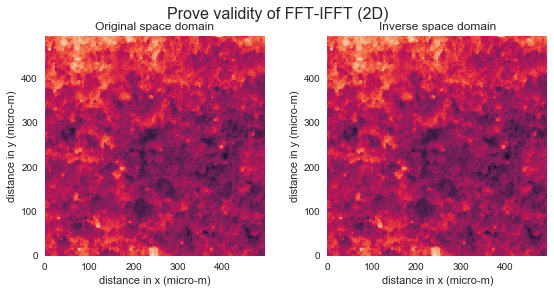

In [54]:
# prove validity of Fourier transform after cut outlier

plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Prove validity of FFT-IFFT (2D)", fontsize=16)

ax1.imshow(df_2D, extent=axis_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Original space domain')
ax1.grid(False)

ax2.imshow(z_inv_2D.real, extent=axis_dist) 
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Inverse space domain')
ax2.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

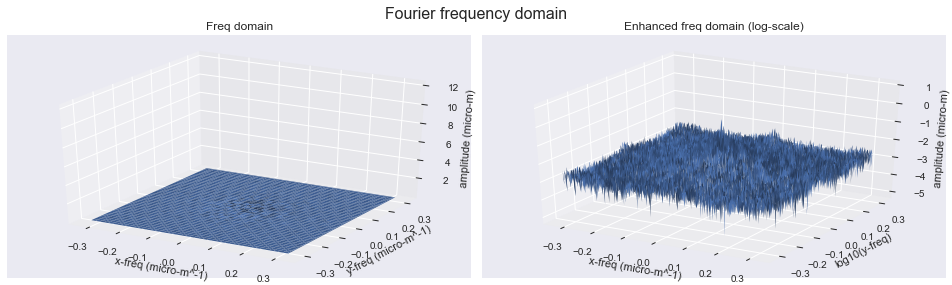

In [55]:
# plot freq domain
# enhance freq domain by log-scale to show difference of freq hight


fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Fourier frequency domain', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_2D_shift)

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq domain')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = np.log10(1/data_pnts**2 * abs(z_fou_2D_shift))                   # log10 to enhance value difference

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='log10(y-freq)', zlabel='amplitude (micro-m)')
ax.title.set_text('Enhanced freq domain (log-scale)')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [56]:
# compare result

rSq_fft_2D = r2_score(df_2D, z_inv_2D.real)

print('Prove validity of Fourier transform 2D')
print('R-square: ', rSq_fft_2D)

Prove validity of Fourier transform 2D
R-square:  1.0


### Smoothing filter

In [57]:
# smoothing convolution

z_fou_smooth_2D = np.multiply(z_fou_2D_shift, df_smooth_gauss)

In [58]:
# shift freq domain back for IFFT operation

z_fou_2D_ishift = ifftshift(z_fou_2D_shift)
z_fou_smooth_2D_ishift = ifftshift(z_fou_smooth_2D)

In [59]:
# inverse Fourier transform

z_inv_2D = ifft2(z_fou_2D_ishift)
z_inv_smooth_2D = ifft2(z_fou_smooth_2D_ishift)

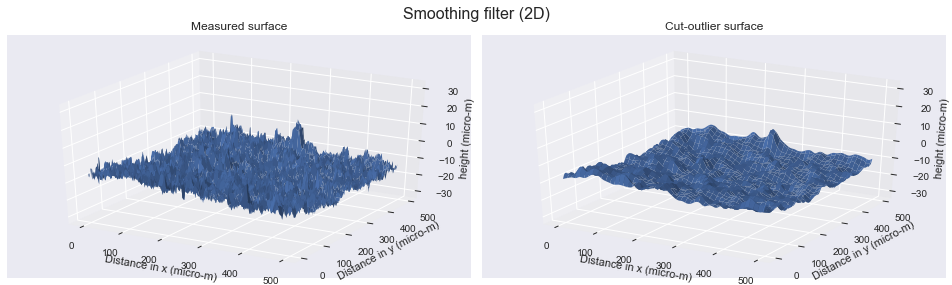

In [60]:
fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Smoothing filter (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Measured surface')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Cut-outlier surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [61]:
# compare result

rSq_ori_corr_2D = r2_score(df_2D, z_inv_smooth_2D.real)

print('Original to cut-outlier surface')
print('R-square: ', rSq_ori_corr_2D)

Original to cut-outlier surface
R-square:  0.8092000485109309


### Waviness-Roughness filter

In [62]:
# convolution by element-wise mulplication in freq domain

## low-pass convolution
z_fou_low_2D = np.multiply(z_fou_smooth_2D, df_low_gauss)


## high-pass convolution
z_fou_high_2D = np.multiply(z_fou_smooth_2D, df_high_gauss)

In [63]:
# shift freq domain back for IFFT operation

z_fou_low_2D_ishift = ifftshift(z_fou_low_2D)
z_fou_high_2D_ishift = ifftshift(z_fou_high_2D)

In [64]:
# inverse Fourier transform

z_inv_low_2D = ifft2(z_fou_low_2D_ishift)
z_inv_high_2D = ifft2(z_fou_high_2D_ishift)

D:\Program\Python\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
D:\Program\Python\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


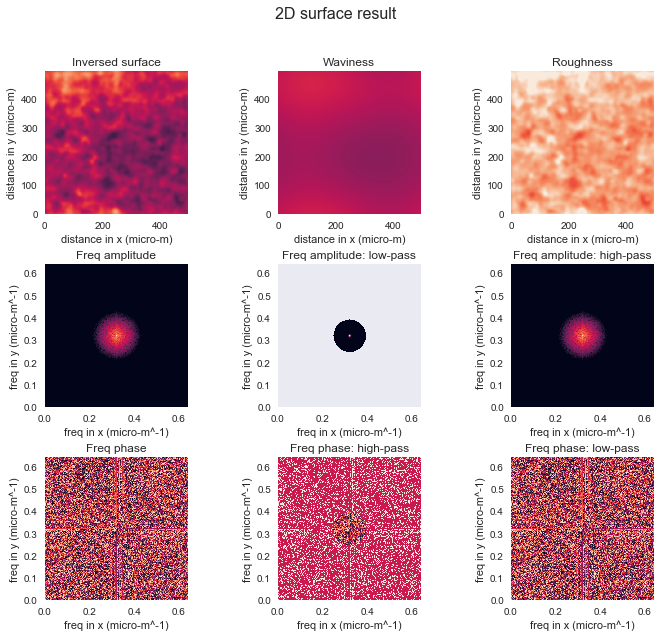

In [65]:
# image plot

plot_size = (10, 9)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=plot_size)
f.suptitle("2D surface result", fontsize=16)

ax1.imshow(z_inv_smooth_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Inversed surface')
ax1.grid(False)

ax2.imshow(z_inv_low_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Waviness')
ax2.grid(False)

ax3.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax3.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax3.title.set_text('Roughness')
ax3.grid(False)

ax4.imshow(np.log10(1/data_pnts**2 * abs(z_fou_smooth_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)    # log10 to enhance the result
ax4.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax4.title.set_text('Freq amplitude')
ax4.grid(False)

ax5.imshow(np.log10(1/data_pnts**2 * abs(z_fou_low_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)      # log10 to enhance the result
ax5.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax5.title.set_text('Freq amplitude: low-pass')
ax5.grid(False)

ax6.imshow(np.log10(1/data_pnts**2 * abs(z_fou_high_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)      # log10 to enhance the result
ax6.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax6.title.set_text('Freq amplitude: high-pass')
ax6.grid(False)

ax7.imshow(np.angle(z_fou_smooth_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax7.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax7.title.set_text('Freq phase')
ax7.grid(False)

ax8.imshow(np.angle(z_fou_low_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax8.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax8.title.set_text('Freq phase: high-pass')
ax8.grid(False)

ax9.imshow(np.angle(z_fou_high_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax9.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax9.title.set_text('Freq phase: low-pass')
ax9.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

D:\Program\Python\lib\site-packages\matplotlib\transforms.py:963: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


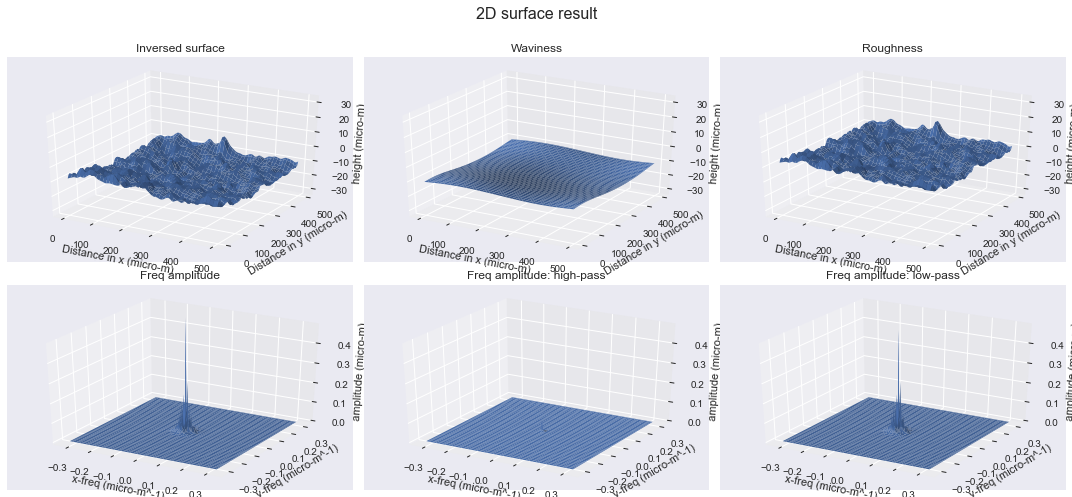

In [66]:
# surface plot

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plot_size = (15, 7)
fig = plt.figure(figsize=plot_size)                                     # set up figure size
fig.suptitle('2D surface result', fontsize=16)


# First subplot
ax = fig.add_subplot(2, 3, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Inversed surface')


# Second subplot
ax = fig.add_subplot(2, 3, 2, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_low_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Waviness')


# third subplot
ax = fig.add_subplot(2, 3, 3, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness')


# fourth subplot
ax = fig.add_subplot(2, 3, 4, projection='3d')          

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_smooth_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude')


# fifth subplot
ax = fig.add_subplot(2, 3, 5, projection='3d')            

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_low_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude: high-pass')


# sixth subplot
ax = fig.add_subplot(2, 3, 6, projection='3d')            

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_high_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude: low-pass')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## 1D and 2D surface comparison

In [67]:
# extract row of 2D surface transformation to compare with 1D surface transformation

if x_or_y == 'x': 
    z_inv_select = z_inv_smooth_2D[:, row_no]
    z_inv_select_low = z_inv_low_2D[:, row_no]
    z_inv_select_high = z_inv_high_2D[:, row_no]
        
if x_or_y == 'y':
    z_inv_select = z_inv_smooth_2D[row_no, :]
    z_inv_select_low = z_inv_low_2D[row_no, :]
    z_inv_select_high = z_inv_high_2D[row_no, :]

D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


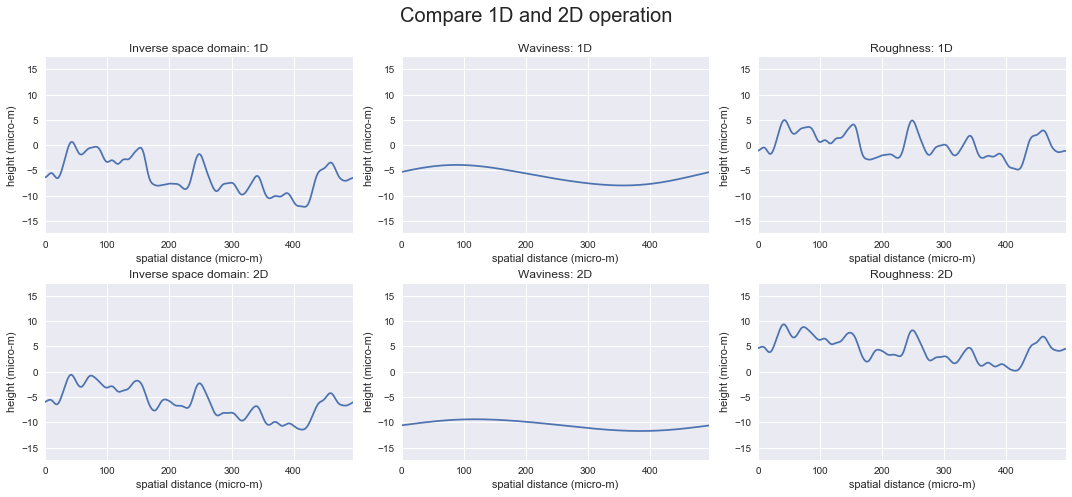

In [68]:
# plot compare 1D and 2D result in 1D-display

plot_size = (15, 7)
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
f.suptitle("Compare 1D and 2D operation", fontsize=20)

ax1.plot(data_list, z_inv_smooth_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Inverse space domain: 1D')

ax2.plot(data_list, z_inv_low_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Waviness: 1D')

ax3.plot(data_list, z_inv_high_1D.real)
ax3.set_xlim(0, plt_dist_xlim_1D)
ax3.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax3.title.set_text('Roughness: 1D')

ax4.plot(data_list, z_inv_select)
ax4.set_xlim(0, plt_dist_xlim_1D)
ax4.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax4.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax4.title.set_text('Inverse space domain: 2D')

ax5.plot(data_list, z_inv_select_low)
ax5.set_xlim(0, plt_dist_xlim_1D)
ax5.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax5.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax5.title.set_text('Waviness: 2D')

ax6.plot(data_list, z_inv_select_high)
ax6.set_xlim(0, plt_dist_xlim_1D)
ax6.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax6.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax6.title.set_text('Roughness: 2D')


plt.tight_layout()
f.subplots_adjust(top=0.88)

In [69]:
# compare result

rSq_inv_1D2D = r2_score(z_inv_select, z_inv_smooth_1D.real)
rSq_wav_1D2D = r2_score(z_inv_select_low, z_inv_low_1D.real)
rSq_rou_1D2D = r2_score(z_inv_select_high,z_inv_high_1D.real)

print('Inverse space domain - 1D to 2D')
print('R-square: ', rSq_inv_1D2D)
print('\nWaviness - 1D to 2D')
print('R-square: ', rSq_wav_1D2D)
print('\nRoughness - 1D to 2D')
print('R-square: ', rSq_rou_1D2D)

D:\Program\Python\lib\site-packages\numpy\core\_methods.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims)


Inverse space domain - 1D to 2D
R-square:  0.9221956108042118

Waviness - 1D to 2D
R-square:  -30.886048818300154

Roughness - 1D to 2D
R-square:  -2.8831853645174514


# Dominant frequency

## 1D dominant freq

In [70]:
# automatically assign cut-off amplitude by ratio to max value of freq

freq_dom_amp_c_1D = ratio_amp_dom2max_1D * z_fou_high_1D_half.max() / 100    # value as shown in graph (half-range)
freq_dom_amp_c_1D_full = freq_dom_amp_c_1D/2                                 # value for extraction operation (full-range)

print(freq_dom_amp_c_1D)
print(freq_dom_amp_c_1D_full)

0.1905294667529771
0.09526473337648855


In [71]:
# create dataframe for operation

df_freq_dom_1D = pd.DataFrame(data=freq_full, columns=['freq'])
df_freq_dom_1D['high_conv'] = z_fou_high_1D_ishift
df_freq_dom_1D['amplitude'] = z_fou_high_1D_full
df_freq_dom_1D['dominant?'] = np.zeros(len(df_freq_dom_1D))
df_freq_dom_1D['f_dom'] = np.zeros(len(df_freq_dom_1D))

In [72]:
# identify dominant freq by boolean True, False

df_freq_dom_1D['dominant?'] = np.where(
    df_freq_dom_1D['amplitude'] >= freq_dom_amp_c_1D_full,
    True,
    False
)


# remain only the value of dominant freq

df_freq_dom_1D['f_dom'] = np.where(
    df_freq_dom_1D['dominant?'] == True,
    df_freq_dom_1D['high_conv'],
    0.0
)

df_freq_dom_1D.head()

,freq,high_conv,amplitude,dominant?,f_dom
0,0.000000,(-0+0j),0.000000,False,0j
1,0.002013,(82.31764650331318-230.53563898653215j),0.769785,True,(82.31764650331318-230.53563898653215j)
2,0.004025,(41.1572230622419-193.60170744344245j),0.622415,True,(41.1572230622419-193.60170744344245j)
3,0.006038,(-50.90705493593756+110.65249575189755j),0.383022,True,(-50.90705493593756+110.65249575189755j)
4,0.008050,(8.186578562365053+50.99822872037652j),0.162425,True,(8.186578562365053+50.99822872037652j)


In [73]:
# normalized amplitude for graph plot

z_fou_dom_1D_full = 1/data_pnts * abs(df_freq_dom_1D['f_dom'].values)
z_fou_dom_1D_half = 2/data_pnts * abs(df_freq_dom_1D['f_dom'].values[0:data_pnts//2])

In [74]:
# inverse Fourier transform

z_inv_dom_1D = ifft(df_freq_dom_1D['f_dom'].values)

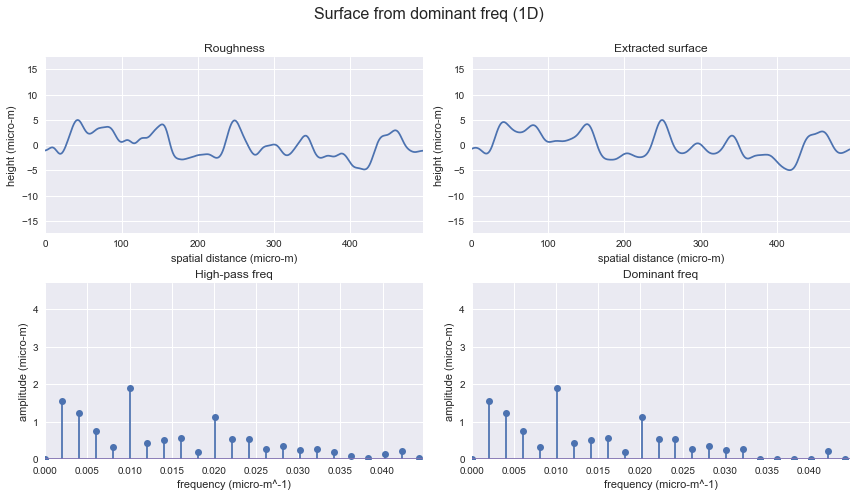

In [75]:
plot_size = (12, 7)
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=plot_size)
f.suptitle("Surface from dominant freq (1D)", fontsize=16)

ax1.plot(data_list, z_inv_high_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Roughness')

ax2.plot(data_list, z_inv_dom_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Extracted surface')

ax3.stem(freq_half, z_fou_high_1D_half)
ax3.set_xlim(0, plt_freq_xlim_1D * 0.07)
ax3.set_ylim(0, plt_freq_zlim_1D * 0.3)
ax3.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax3.title.set_text('High-pass freq')

ax4.stem(freq_half, z_fou_dom_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.07)
ax4.set_ylim(0, plt_freq_zlim_1D * 0.3)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Dominant freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [76]:
# count amount of dominant freq 1D
f_dom_no_1D = (df_freq_dom_1D['dominant?'] == True).astype(int).values.sum()

print('Amount of dominant freq: ', f_dom_no_1D)

Amount of dominant freq:  34


In [77]:
# compare result

rSq_rou2dom_1D = r2_score(z_inv_high_1D.real, z_inv_dom_1D.real)

print('Roughness to Dominant surface 1D')
print('R-square: ', rSq_rou2dom_1D)

Roughness to Dominant surface 1D
R-square:  0.9913841054045209


## 2D dominant freq

### Autimatically assign cut-off amplitude

In [78]:
# prepare dataframe for loop operation

df_freq = pd.DataFrame(data = z_fou_high_2D_ishift,
                       index = freq_full,
                       columns = freq_full)

df_freq_amp = abs(df_freq)

In [79]:
# prepare list of freq -> to find cut-off amplitude of dominant freq

list_freq_amp = df_freq_amp.values.flatten()
list_freq_amp = sorted(list_freq_amp)

In [80]:
# create table to compare result based on amount of dominant freq

# no_dom_freq_per = np.array([0.0025,0.005,0.01,
#                             0.02,0.04,0.06,0.08,0.1,
#                             0.2,0.4,0.6,0.8,1.0,
#                             1.5,2.0,5.0,10.0,20.0,30.0])

no_dom_freq_per = np.array([10.0,20.0,30.0,40.0,50.0])

df_dom_samp = pd.DataFrame(data = no_dom_freq_per, columns = ['no_f_per'])
df_dom_samp['no_f'] = df_dom_samp['no_f_per'] * len(list_freq_amp) / 100
df_dom_samp['no_f_int'] = df_dom_samp['no_f'].astype(int) + 1
df_dom_samp['f_dom_amp_c'] = np.zeros(len(no_dom_freq_per))
df_dom_samp['result_error'] = np.zeros(len(no_dom_freq_per))

In [81]:
# find cut-off amplitude for dominant freq

for i in range(len(no_dom_freq_per)):
    df_dom_samp.loc[i,'f_dom_amp_c'] = list_freq_amp[-df_dom_samp.loc[i,'no_f_int']]
    
df_dom_samp.head()

,no_f_per,no_f,no_f_int,f_dom_amp_c,result_error
0,10.0,10112.4,10113,1.474862e-01,0.0
1,20.0,20224.8,20225,2.448397e-05,0.0
2,30.0,30337.2,30338,5.148689e-09,0.0
3,40.0,40449.6,40450,1.251375e-12,0.0
4,50.0,50562.0,50563,3.314561e-16,0.0


D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


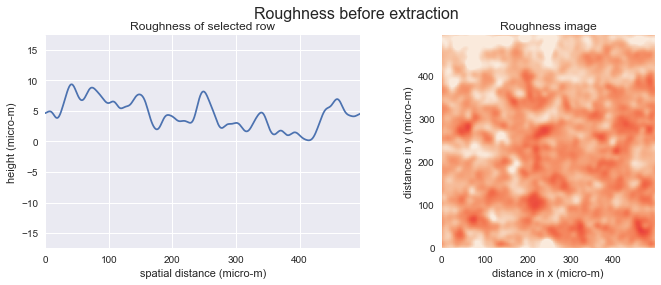

In [82]:
# roughness plot

plot_size = (10, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Roughness before extraction", fontsize=16)

ax1.plot(data_list, z_inv_select_high)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Roughness of selected row')

ax2.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Roughness image')
ax2.grid(False)


plt.tight_layout()
f.subplots_adjust(top=0.88)

In [83]:
def find_error_dom_f(no_f_per, freq_dom_amp_c):

    df_freq_dom = df_freq.copy()
    
    for x in df_freq.columns:
        df_freq_dom[x] = np.where(
            df_freq_amp[x] > freq_dom_amp_c,
            df_freq_dom[x],
            0.0
        )
    
    z_fou_dom = df_freq_dom.values
    z_inv_dom_2D = ifft2(z_fou_dom)

#----------------------------------------------------------------------------------------------------------------------------#
    
    # find error
    
    rSq_rou2dom_2D = r2_score(z_inv_high_2D.real, z_inv_dom_2D.real)
    
#----------------------------------------------------------------------------------------------------------------------------#

    # extract row for 1D plot

    if x_or_y == 'x': 
        z_inv_select_dom = z_inv_dom_2D[:, row_no]
        
    if x_or_y == 'y':
        z_inv_select_dom = z_inv_dom_2D[row_no, :]
    
#----------------------------------------------------------------------------------------------------------------------------#

    # plot graph to compare
    
    
    title = 'No. of selected dom freq: ' + str(no_f_per) + ', R-Square error: ' + str("{0:.2f}".format(rSq_rou2dom_2D))
        
    plot_size = (10, 4)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
    f.suptitle(title, fontsize=16)
    axis_dist = (0, data_len, 0, data_len)                                             # assign axis for spatial domain
    axis_freq = (0, samp_rate, 0, samp_rate)                                           # assign axis for freq domain

    ax1.plot(data_list, z_inv_select_dom)
    ax1.set_xlim(0, plt_dist_xlim_1D)
    ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
    ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
    ax1.title.set_text('Roughness of selected row')

    ax2.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
    ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax2.title.set_text('Roughness image')
    ax2.grid(False)

    plt.tight_layout()
    f.subplots_adjust(top=0.88)
    
    
    return rSq_rou2dom_2D

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


,no_f_per,no_f,no_f_int,f_dom_amp_c,result_error
0,10.0,10112.4,10113,1.474862e-01,1.0
1,20.0,20224.8,20225,2.448397e-05,1.0
2,30.0,30337.2,30338,5.148689e-09,1.0
3,40.0,40449.6,40450,1.251375e-12,1.0
4,50.0,50562.0,50563,3.314561e-16,1.0


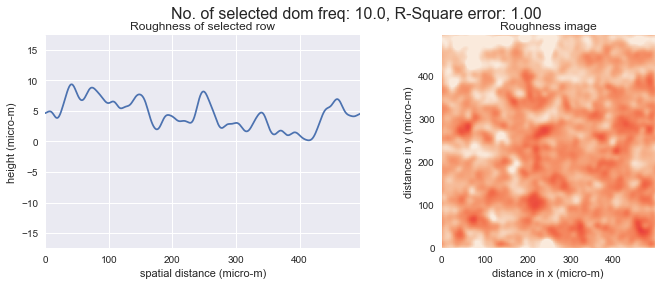

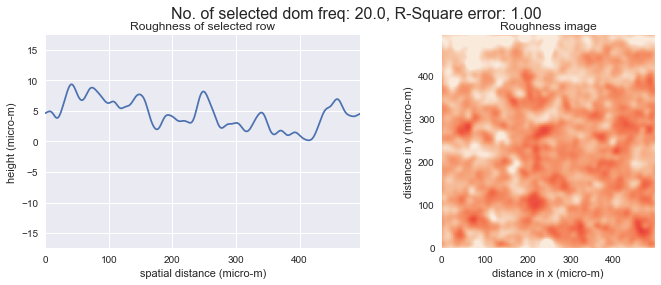

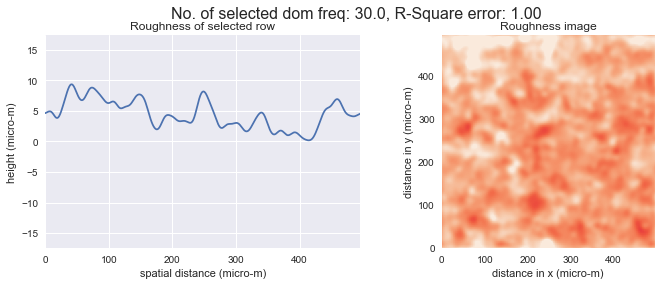

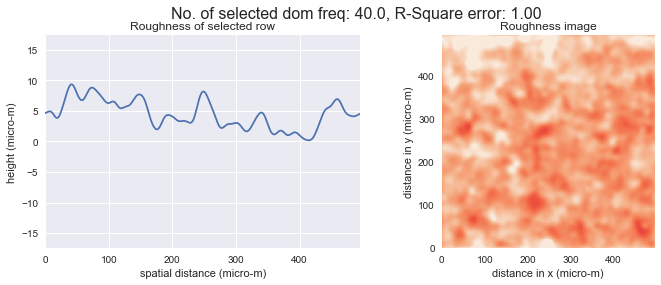

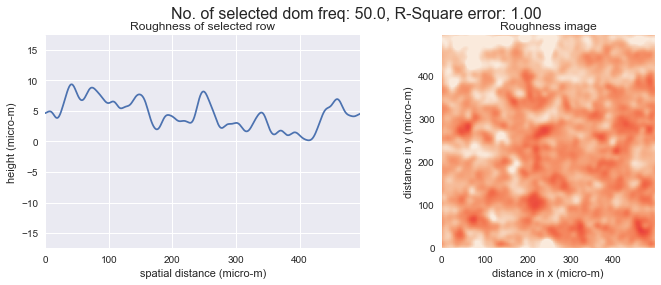

In [84]:
# find result error between roughness and extracted surface

for i in tqdm(range(len(no_dom_freq_per))):
    df_dom_samp.loc[i,'result_error'] = find_error_dom_f(df_dom_samp.loc[i,'no_f_per'], df_dom_samp.loc[i,'f_dom_amp_c'])
    
df_dom_samp

In [85]:
# automatically assign cut-off dominant amplitude by acceptable percentage of error

for i in range(len(no_dom_freq_per)):
    if df_dom_samp.loc[i,'result_error'] > accept_dom_rSqua_2D:
        freq_dom_amp_c_2D = df_dom_samp.loc[i,'f_dom_amp_c']
        break
            
freq_dom_amp_c_2D

0.14748624571048968

### Extraction operation

In [86]:
# remain only dominant freq in matrix

df_freq_dom = df_freq.copy()
    
for x in df_freq.columns:
    df_freq_dom[x] = np.where(
        df_freq_amp[x] > freq_dom_amp_c_2D,
        df_freq_dom[x],
        0.0
    )

In [87]:
z_fou_dom = df_freq_dom.values
z_inv_dom_2D = ifft2(z_fou_dom)

z_fou_dom_shift = fftshift(z_fou_dom)
z_fou_dom_ishift = ifftshift(z_fou_dom_shift)

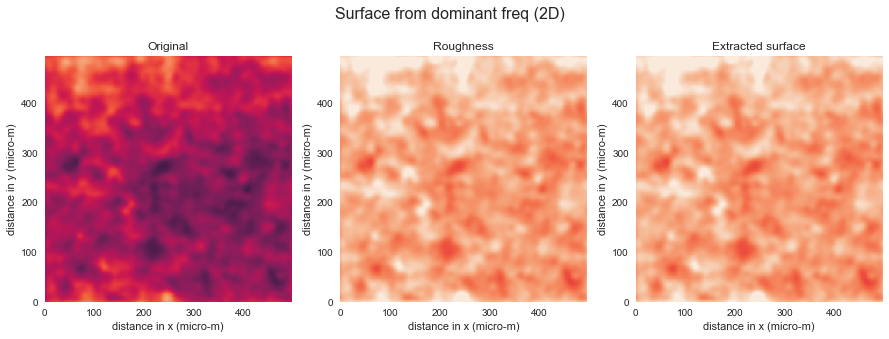

In [88]:
# plot surface image

plot_size = (15, 5)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Surface from dominant freq (2D)", fontsize=16)

ax1.imshow(z_inv_smooth_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Original')
ax1.grid(False)

ax2.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Roughness')
ax2.grid(False)

ax3.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist) 
ax3.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax3.title.set_text('Extracted surface')
ax3.grid(False)

D:\Program\Python\lib\site-packages\matplotlib\transforms.py:963: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


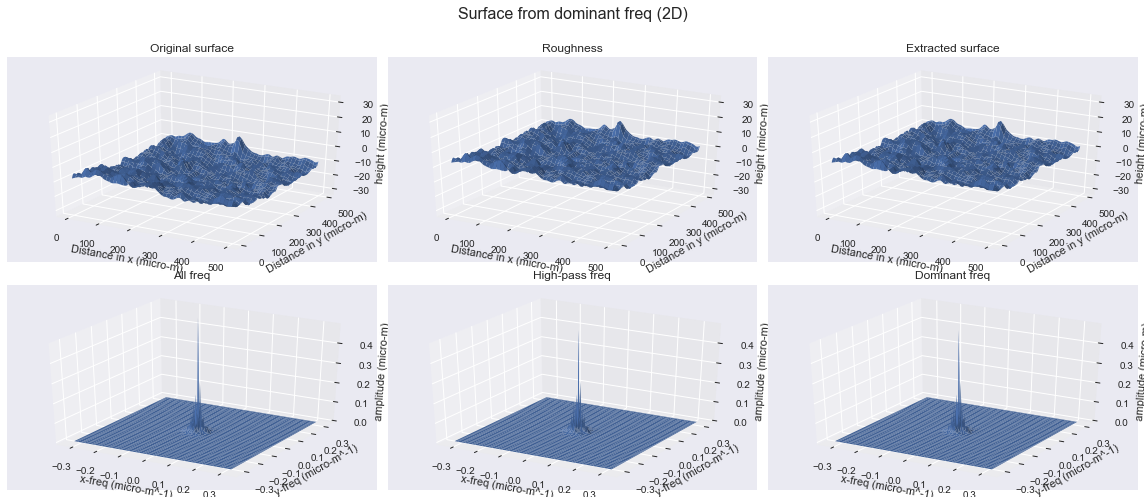

In [89]:
# plot surface 3D

plot_size = (16, 7)
fig = plt.figure(figsize=plot_size)
fig.suptitle('Surface from dominant freq (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(2, 3, 1, projection='3d') 

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Original surface')


# Second subplot
ax = fig.add_subplot(2, 3, 2, projection='3d')

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness')


# third subplot
ax = fig.add_subplot(2, 3, 3, projection='3d')

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_dom_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Extracted surface')


# fourth subplot
ax = fig.add_subplot(2, 3, 4, projection='3d')          

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_smooth_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('All freq')


# fifth subplot
ax = fig.add_subplot(2, 3, 5, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_high_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('High-pass freq')


# sixth subplot
ax = fig.add_subplot(2, 3, 6, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_dom_shift)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Dominant freq')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [90]:
# count amount of dominant freq
f_dom_no = (df_freq_dom != 0).astype(int).values.sum()

print('Amount of dominant freq: ', f_dom_no)

Amount of dominant freq:  10112


In [91]:
# compare result 

rSq_rou2dom_2D = r2_score(z_inv_high_2D.real, z_inv_dom_2D.real)

print('Roughness to Dominant surface 2D')
print('R-square: ', rSq_rou2dom_2D)

Roughness to Dominant surface 2D
R-square:  0.9999999997327103


# Import data to csv file

## 1D import file

### Variables of full-frequency

In [92]:
df_excel_1D = df_freq_dom_1D[['freq', 'high_conv', 'amplitude', 'dominant?']].copy()

# keep only rows with dominant freq
df_excel_1D = df_excel_1D[(df_excel_1D[['dominant?']] == True).any(axis=1)]
df_excel_1D = df_excel_1D.reset_index(drop=True)

In [93]:
df_excel_1D = df_excel_1D.drop(['dominant?'], axis=1)
df_excel_1D = df_excel_1D.rename(index=str, columns={'freq':'f(um)^-1', 
                                                     'high_conv':'FourierCoef', 
                                                     'amplitude':'A(um)'
                                                    })

df_excel_1D['FourierCoef'] = df_excel_1D['FourierCoef'] / data_pnts
df_excel_1D['Phs(rad)'] = np.angle(df_excel_1D['FourierCoef'])

### Variables of half-frequency

In [94]:
# keep only positive freq

df_excel_1D_pos = df_excel_1D.copy()
df_excel_1D_pos = df_excel_1D_pos[(df_excel_1D_pos[['f(um)^-1']] >= 0).any(axis=1)]
df_excel_1D_pos = df_excel_1D_pos.reset_index(drop=True)

In [95]:
# correct the amplitude by *2

f_dom_no_1D_pos = int(f_dom_no_1D/2)

df_excel_1D_pos['FourierCoef'] = np.where(
    df_excel_1D_pos['f(um)^-1'] == 0,
    df_excel_1D_pos['FourierCoef'],
    2 * df_excel_1D_pos['FourierCoef']
)

df_excel_1D_pos['A(um)'] = np.where(
    df_excel_1D_pos['f(um)^-1'] == 0,
    df_excel_1D_pos['A(um)'],
    2 * df_excel_1D_pos['A(um)']
)

df_excel_1D_pos.head()

,f(um)^-1,FourierCoef,A(um),Phs(rad)
0,0.002013,(0.517721047190649-1.4499096791605797j),1.539569,-1.227836
1,0.004025,(0.25885045951095537-1.2176208015310848j),1.244831,-1.361328
2,0.006038,(-0.320170156829796+0.6959276462383494j),0.766045,2.001987
3,0.008050,(0.051487915486572666+0.320743576857714j),0.324850,1.411628
4,0.010063,(-1.8710305983266515+0.3597113707443691j),1.905295,2.951657


In [96]:
print('Amount of dominant freq (full): ', f_dom_no_1D)
print('Amount of dominant freq (half): ', f_dom_no_1D_pos)

Amount of dominant freq (full):  34
Amount of dominant freq (half):  17


In [97]:
# # import dataframe to csv

# df_excel_1D_pos.to_csv('onefile_variables_1D.csv', index=False)

### Height of dominant surface

In [98]:
df_excel_1D_z_dom = pd.DataFrame(data = data_list, columns = ['x(um)'])
df_excel_1D_z_dom['z(um)'] = z_inv_dom_1D.real

df_excel_1D_z_dom.head()

,x(um),z(um)
0,0.0000,-0.739520
1,1.5625,-0.640113
2,3.1250,-0.569997
3,4.6875,-0.538870
4,6.2500,-0.554932


In [99]:
# # cut length of imported height as assign

# if assign_csv_len == 'y':
#     df_excel_1D_z_dom = df_excel_1D_z_dom.iloc[0:csv_len_1D]

# print('Processed length: ', data_pnts)
# print('Imported length:  ', len(df_excel_1D_z_dom))

In [100]:
# # import dataframe to csv

# df_excel_1D_z_dom.to_csv('onefile_height_1D.csv', index=False)

## 2D import file

### Variables of full-frequency

In [101]:
df_freq_dom = pd.DataFrame(data = z_fou_dom_ishift)

# assign index to dataframe
df_freq_dom.index = freq_full
df_freq_dom.columns = freq_full

In [102]:
# unpivot table of df_freq_dom

df_excel_2D = df_freq_dom.unstack().reset_index(name='FourierCoef')
df_excel_2D.rename(columns={'level_0': 'fx(um)^-1', 'level_1': 'fy(um)^-1'}, inplace=True)

In [103]:
# assign amplitude and phase

df_excel_2D['FourierCoef'] = df_excel_2D['FourierCoef'] / data_pnts**2
df_excel_2D['A(um)'] = np.abs(df_excel_2D['FourierCoef'])
df_excel_2D['Phs(rad)'] = np.angle(df_excel_2D['FourierCoef'])


# remain only dominant freq

df_excel_2D = df_excel_2D[(df_excel_2D[['FourierCoef']] != 0).any(axis=1)]
df_excel_2D = df_excel_2D.reset_index(drop=True)

### Variables of half-frequency

In [104]:
# remain only freq in half positive quarters

df_excel_2D_half = df_excel_2D.copy()
df_excel_2D_half = df_excel_2D_half[(df_excel_2D_half[['fx(um)^-1']] >= 0).any(axis=1)]
df_excel_2D_half = df_excel_2D_half.reset_index(drop=True)

In [105]:
# correct the amplitude by *2

f_dom_no_half = len(df_excel_2D_half)

df_excel_2D_half['FourierCoef'] = np.where(
    df_excel_2D_half['fx(um)^-1'] == 0,
    df_excel_2D_half['FourierCoef'],
    2 * df_excel_2D_half['FourierCoef']
)

df_excel_2D_half['A(um)'] = np.where(
    df_excel_2D_half['fx(um)^-1'] == 0,
    df_excel_2D_half['A(um)'],
    2 * df_excel_2D_half['A(um)']
)

df_excel_2D_half.head()

,fx(um)^-1,fy(um)^-1,FourierCoef,A(um),Phs(rad)
0,0.0,0.002013,(0.539582145994611-0.38016917598308053j),0.660059,-0.613781
1,0.0,0.004025,(0.23154722702416627-0.4552380073763916j),0.510740,-1.100269
2,0.0,0.006038,(0.14303208887965496-0.14082536119670586j),0.200724,-0.777624
3,0.0,0.008050,(0.19743925840519277-0.21086913906276797j),0.288874,-0.818278
4,0.0,0.010063,(0.18579554748620783-0.06207405560035727j),0.195891,-0.322439


In [106]:
print('Amount of dominant freq (full): ', f_dom_no)
print('Amount of dominant freq (half): ', f_dom_no_half)

Amount of dominant freq (full):  10112
Amount of dominant freq (half):  5116


In [107]:
# # import dataframe to csv

# df_excel_2D_half.to_csv('onefile_variables_2D.csv', index=False)

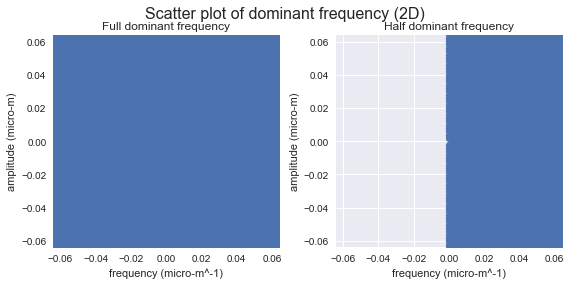

In [108]:
# scatter plot to compare full & half dominant freq

axis_freq = (0, samp_rate, 0, samp_rate)

plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Scatter plot of dominant frequency (2D)", fontsize=16)


## plot1
data = df_excel_2D[['fx(um)^-1', 'fy(um)^-1']].values
x1, y1 = data.T

ax1.scatter(x1,y1)
ax1.set_xlim((-samp_rate * 0.1, samp_rate * 0.1))
ax1.set_ylim((-samp_rate * 0.1, samp_rate * 0.1))
ax1.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax1.title.set_text('Full dominant frequency')


## plot2
data = df_excel_2D_half[['fx(um)^-1', 'fy(um)^-1']].values
x2, y2 = data.T

ax2.scatter(x2,y2)
ax2.set_xlim((-samp_rate * 0.1, samp_rate * 0.1))
ax2.set_ylim((-samp_rate * 0.1, samp_rate * 0.1))
ax2.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax2.title.set_text('Half dominant frequency')


plt.tight_layout()
f.subplots_adjust(top=0.88)

### Height of dominant surface

In [109]:
df_excel_2D_z_dom = pd.DataFrame(data = z_inv_dom_2D.real, columns = data_list)
df_excel_2D_z_dom.index = data_list

df_excel_2D_z_dom.iloc[0:5,0:5]

,0.0,1.5625,3.125,4.6875,6.25
0.0000,2.285352,2.425703,2.553516,2.669972,2.776734
1.5625,3.067292,3.131347,3.183319,3.227959,3.269081
3.1250,3.747946,3.747623,3.734335,3.716042,3.698623
4.6875,4.289322,4.241811,4.179568,4.113091,4.049891
6.2500,4.677780,4.603118,4.511795,4.415810,4.323435


In [110]:
# cut length of imported height as assign

if assign_csv_len == 'y':
    df_excel_2D_z_dom = df_excel_2D_z_dom.iloc[
        int(data_pnts/2):int(data_pnts/2+csv_len_2D), int(data_pnts/2):int(data_pnts/2+csv_len_2D)]

print('Processed length: ', data_pnts)
print('Imported length:  ', len(df_excel_2D_z_dom))

Processed length:  318
Imported length:   318


In [111]:
# unpivot table

temp = df_excel_2D_z_dom.stack()
df_excel_2D_z_dom_melt = pd.DataFrame(temp)
df_excel_2D_z_dom_melt.columns = ['z']
df_excel_2D_z_dom_melt = df_excel_2D_z_dom_melt.reset_index()
df_excel_2D_z_dom_melt = df_excel_2D_z_dom_melt.rename(index=str, columns={'level_0': 'x',
                                                                           'level_1': 'y'})

df_excel_2D_z_dom_melt.head()

,x,y,z
0,0.0,0.0000,2.285352
1,0.0,1.5625,2.425703
2,0.0,3.1250,2.553516
3,0.0,4.6875,2.669972
4,0.0,6.2500,2.776734


In [112]:
# rearrange data
shiftValue = df_excel_2D_z_dom_melt.iloc[0,0]

df_excel_2D_z_dom_melt['x'] = df_excel_2D_z_dom_melt['x'] - shiftValue - data_len_recon/2
df_excel_2D_z_dom_melt['y'] = df_excel_2D_z_dom_melt['y'] - shiftValue - data_len_recon/2
df_excel_2D_z_dom_melt['z'] = df_excel_2D_z_dom_melt['z']
df_excel_2D_z_dom_melt.columns = ['z', 'x', 'y']

df_excel_2D_z_dom_melt.head()

,z,x,y
0,-250.0,-250.0000,2.285352
1,-250.0,-248.4375,2.425703
2,-250.0,-246.8750,2.553516
3,-250.0,-245.3125,2.669972
4,-250.0,-243.7500,2.776734


In [113]:
# # import dataframe to csv

# df_excel_2D_z_dom_melt.to_csv('onefile_height_2D.csv', index=False)

# Surface reconstruction

## 1D surface reconstruction

In [114]:
# reconstruct surface by superposition of sinusoidal wave

z_recon_1D_pos = np.zeros(data_pnts_recon)
x = np.array(data_list_recon)

for i in tqdm(range(f_dom_no_1D_pos)):
    
    A = df_excel_1D_pos['A(um)'].iloc[i]
    f = df_excel_1D_pos['f(um)^-1'].iloc[i]
    ph = df_excel_1D_pos['Phs(rad)'].iloc[i]
        
    zi = A * np.cos(2*np.pi*f*x + ph)
    z_recon_1D_pos = z_recon_1D_pos + zi
    
z_recon_1D_pos[0:5]

100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17078.60it/s]


array([-0.73951961, -0.75019512,  3.57313588,  3.5303139 ,  0.62815694])

In [115]:
df_1D_z_recon = pd.DataFrame(data = data_list_recon, columns = ['x'])
df_1D_z_recon['z'] = z_recon_1D_pos.real

df_1D_z_recon.head()

,x,z
0,0.0,-0.739520
1,25.0,-0.750195
2,50.0,3.573136
3,75.0,3.530314
4,100.0,0.628157


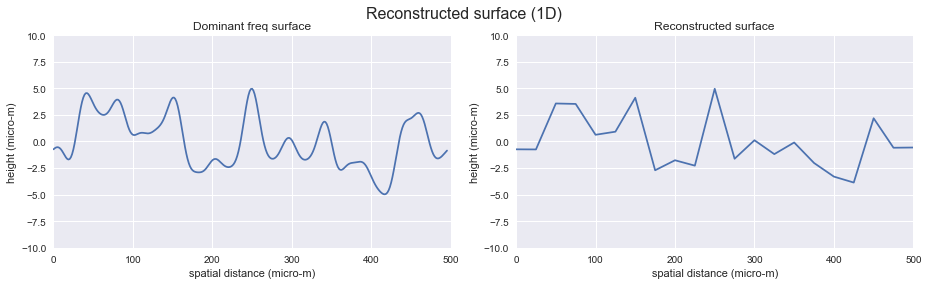

In [116]:
plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Reconstructed surface (1D)", fontsize=16)

ax1.plot(data_list, z_inv_dom_1D.real)
ax1.set_xlim(0, data_len_recon)
ax1.set_ylim(-10, 10)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Dominant freq surface')

ax2.plot(data_list_recon, z_recon_1D_pos)
ax2.set_xlim(0, data_len_recon)
ax2.set_ylim(-10, 10)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Reconstructed surface')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [117]:
# # import dataframe to csv

# df_1D_z_recon.to_csv('1D_recon_WireCut2_1.csv', index=False)

In [118]:
# # compare result

# rSq_dom2recon_1D = r2_score(z_inv_dom_1D.real, z_recon_1D_pos)
# rSq_rou2recon_1D = r2_score(z_inv_high_1D.real, z_recon_1D_pos)

# print('Dominant to reconstructed surface 1D')
# print('R-square: ', rSq_dom2recon_1D)
# print('\nRoughness to reconstructed surface 1D')
# print('R-square: ', rSq_rou2recon_1D)

## 2D surface reconstruction

In [119]:
# reconstruct surface by superposition of sinusoidal wave

z_recon_2D_half = pd.DataFrame(np.zeros((data_pnts_recon, data_pnts_recon)))
x, y = np.meshgrid(data_list_recon, data_list_recon)

for i in tqdm(range(f_dom_no_half)):
    
    A = df_excel_2D_half['A(um)'].iloc[i]
    fx = df_excel_2D_half['fx(um)^-1'].iloc[i]
    fy = df_excel_2D_half['fy(um)^-1'].iloc[i]
    ph = df_excel_2D_half['Phs(rad)'].iloc[i]
    
    zi = A * np.cos(2*np.pi*(fx*x + fy*y) + ph)
    z_recon_2D_half = z_recon_2D_half + zi
    
z_recon_2D_half.iloc[0:5,0:5]

100%|████████████████████████████████████████████████████████████████████████████| 5116/5116 [00:01<00:00, 2744.61it/s]


,0,1,2,3,4
0,2.285352,3.653432,4.174698,6.485685,4.845465
1,2.959668,4.429133,5.158352,7.838684,5.096001
2,0.563872,1.678022,2.969176,7.317592,1.623966
3,1.994305,1.563458,1.546263,5.829059,3.623178
4,0.203265,4.704907,1.737643,2.693032,-1.333914


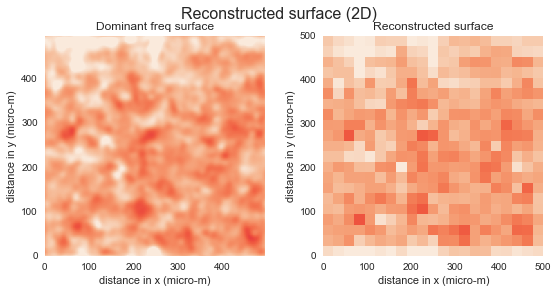

In [120]:
plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Reconstructed surface (2D)", fontsize=16)

ax1.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Dominant freq surface')
ax1.grid(False)

ax2.imshow(z_recon_2D_half.values.real, extent=axis_dist_recon, vmin=v_min_dist, vmax=v_max_dist) 
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Reconstructed surface')
ax2.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

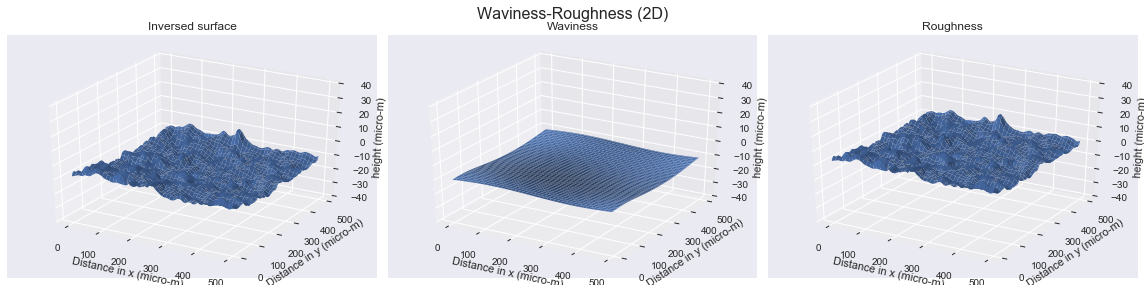

In [121]:
fig = plt.figure(figsize=plt.figaspect(0.25))
fig.suptitle('Waviness-Roughness (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 3, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Inversed surface')


# Second subplot
ax = fig.add_subplot(1, 3, 2, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_low_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Waviness')


# third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [122]:
# prepare axis for roughness and dominant plot

plot_max_loc = 0

for i in range(len(data_list)):
    if data_list[len(data_list)-1-i] < elemsize_recon:
        plot_max_loc = len(data_list)-1-i
        break

plot_data_list = x_list[0:plot_max_loc]
        
print(plot_max_loc)
print(data_list[plot_max_loc])

317
495.31199999999995


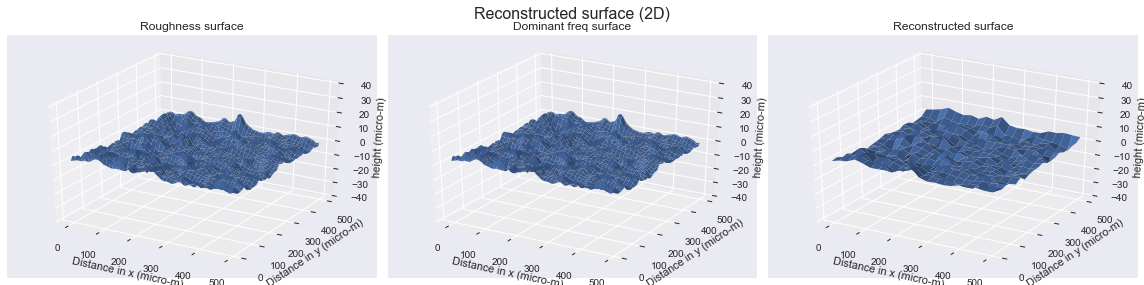

In [123]:
fig = plt.figure(figsize=plt.figaspect(0.25))
fig.suptitle('Reconstructed surface (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 3, 1, projection='3d')           

X = plot_data_list
Y = plot_data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real
Z = Z[0: plot_max_loc, 0: plot_max_loc]

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness surface')


# Second subplot
ax = fig.add_subplot(1, 3, 2, projection='3d')           

X = plot_data_list
Y = plot_data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_dom_2D.real
Z = Z[0: plot_max_loc, 0: plot_max_loc]

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Dominant freq surface')


# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')           

X = data_list_recon
Y = data_list_recon
X, Y = np.meshgrid(X, Y)
Z = z_recon_2D_half.values.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Reconstructed surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

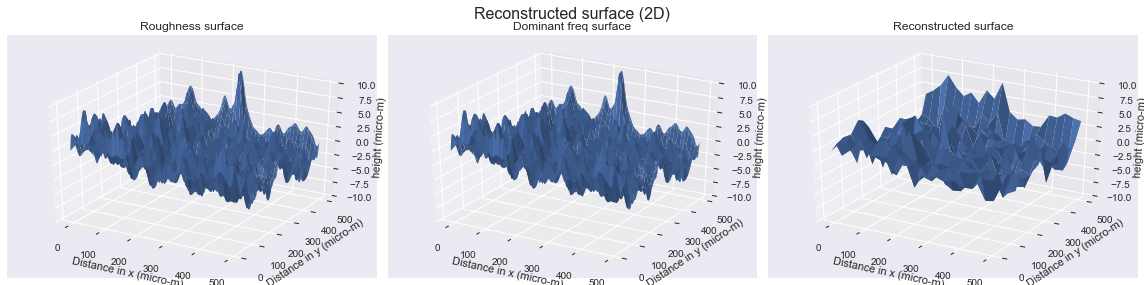

In [124]:
fig = plt.figure(figsize=plt.figaspect(0.25))
fig.suptitle('Reconstructed surface (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 3, 1, projection='3d')           

X = plot_data_list
Y = plot_data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real
Z = Z[0: plot_max_loc, 0: plot_max_loc]

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness surface')


# Second subplot
ax = fig.add_subplot(1, 3, 2, projection='3d')           

X = plot_data_list
Y = plot_data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_dom_2D.real
Z = Z[0: plot_max_loc, 0: plot_max_loc]

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Dominant freq surface')


# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')           

X = data_list_recon
Y = data_list_recon
X, Y = np.meshgrid(X, Y)
Z = z_recon_2D_half.values.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Reconstructed surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [125]:
# # import dataframe to csv

# z_recon_2D_half.to_csv(fileName2D + '_pivot.csv')

In [126]:
# compare result

rSq_dom2recon_2D = r2_score(z_inv_dom_2D.real[0: data_pnts_recon, 0: data_pnts_recon], z_recon_2D_half.values.real)
rSq_rou2recon_2D = r2_score(z_inv_high_2D.real[0: data_pnts_recon, 0: data_pnts_recon], z_recon_2D_half.values.real)

print('Dominant to reconstructed surface 2D')
print('R-square: ', rSq_dom2recon_2D)
print('\nRoughness to reconstructed surface 2D')
print('R-square: ', rSq_rou2recon_2D)

Dominant to reconstructed surface 2D
R-square:  -61.86466886809183

Roughness to reconstructed surface 2D
R-square:  -61.864461063000014


In [127]:
# unpivot table

temp = z_recon_2D_half.stack()
df2D_recon_melt = pd.DataFrame(temp)
df2D_recon_melt.columns = ['z']
df2D_recon_melt = df2D_recon_melt.reset_index()
df2D_recon_melt = df2D_recon_melt.rename(index=str, columns={'level_0': 'x', 'level_1': 'y'})
df2D_recon_melt.columns = ['x', 'z', 'y']

df2D_recon_melt.head()

,x,z,y
0,0,0,2.285352
1,0,1,3.653432
2,0,2,4.174698
3,0,3,6.485685
4,0,4,4.845465


In [128]:
# rearrange data

df2D_recon_melt['z'] = df2D_recon_melt['z'] * data_interval_recon
df2D_recon_melt['y'] = df2D_recon_melt['y']
df2D_recon_melt['x'] = df2D_recon_melt['x'] * data_interval_recon

df2D_recon_melt.head()

,x,z,y
0,0.0,0.0,2.285352
1,0.0,25.0,3.653432
2,0.0,50.0,4.174698
3,0.0,75.0,6.485685
4,0.0,100.0,4.845465


In [129]:
# switch x and z columns for correct load apply

columnsTitles=['z', 'x', 'y']
df2D_recon_melt = df2D_recon_melt.reindex(columns = columnsTitles)

df2D_recon_melt = df2D_recon_melt.sort_values(by=['z', 'x'])

df2D_recon_melt.head()

,z,x,y
0,0.0,0.0,2.285352
21,0.0,25.0,2.959668
42,0.0,50.0,0.563872
63,0.0,75.0,1.994305
84,0.0,100.0,0.203265


In [130]:
# # prepare file name

# elemForName = '_' + str(elemsize_recon) + 'um'

# pntForName = '_' + str(data_pnts_recon) + 'pnts'

# if trim_command == 'n':
#     trimForName = '_noTrim'
# if trim_command == 'y': 
#     trimForName = '_trim' + str(trim_min) + '-' + str(trim_max) 

# outputFileName = 'recon2D_' + input_file[:-4] + elemForName + pntForName + trimForName + '_roughness'

# print(outputFileName)

In [131]:
# # import dataframe to csv (reconstructed surface)

# df2D_recon_melt.to_csv(outputFileName + '.csv', index=False)

### Selected area of reconstructed surface

In [132]:
x_select = 25
z_select = 25

elemsize_select = 450

x_select_end = x_select + elemsize_select
z_select_end = z_select + elemsize_select

In [133]:
df2D_recon_select = df2D_recon_melt.reset_index(drop=True)
df2D_recon_select.head()

,z,x,y
0,0.0,0.0,2.285352
1,0.0,25.0,2.959668
2,0.0,50.0,0.563872
3,0.0,75.0,1.994305
4,0.0,100.0,0.203265


In [134]:
# find index for selected area (z select)

select_min_loc = 0
select_max_loc = 0

select_data_list = df2D_recon_select['z'].values

for i in range(len(select_data_list)):
    if select_data_list[i] == z_select:
        select_min_loc = i
        break

for i in range(len(select_data_list)):
    if select_data_list[len(select_data_list)-1-i] == z_select_end:
        select_max_loc = len(select_data_list)-1-i
        break

print(select_min_loc)
print(select_max_loc)

21
419


In [135]:
# trim for selected area (z_select)

df2D_recon_select = df2D_recon_select.iloc[select_min_loc: select_max_loc]
df2D_recon_select.head()

,z,x,y
21,25.0,0.0,3.653432
22,25.0,25.0,4.429133
23,25.0,50.0,1.678022
24,25.0,75.0,1.563458
25,25.0,100.0,4.704907


In [136]:
# sort 'x' for trimming
df2D_recon_select = df2D_recon_select.sort_values(by=['x', 'z'])
df2D_recon_select = df2D_recon_select.reset_index(drop=True)
df2D_recon_select.head()

,z,x,y
0,25.0,0.0,3.653432
1,50.0,0.0,4.174698
2,75.0,0.0,6.485685
3,100.0,0.0,4.845465
4,125.0,0.0,2.789814


In [137]:
# find index for selected area (x select)

select_min_loc = 0
select_max_loc = 0

select_data_list = df2D_recon_select['x'].values

for i in range(len(select_data_list)):
    if select_data_list[i] == x_select:
        select_min_loc = i
        break

for i in range(len(select_data_list)):
    if select_data_list[len(select_data_list)-1-i] == x_select_end:
        select_max_loc = len(select_data_list)-i
        break

print(select_min_loc)
print(select_max_loc)

19
380


In [138]:
# trim for selected area (x_select)

df2D_recon_select = df2D_recon_select.iloc[select_min_loc: select_max_loc]
df2D_recon_select.head()

,z,x,y
19,25.0,25.0,4.429133
20,50.0,25.0,5.158352
21,75.0,25.0,7.838684
22,100.0,25.0,5.096001
23,125.0,25.0,4.184334


In [139]:
# final sort and arrange data

df2D_recon_select = df2D_recon_select.sort_values(by=['z', 'x'])
df2D_recon_select = df2D_recon_select.reset_index(drop=True)

df2D_recon_select['z'] = df2D_recon_select['z'] - z_select
df2D_recon_select['x'] = df2D_recon_select['x'] - x_select

df2D_recon_select.head()

,z,x,y
0,0.0,0.0,4.429133
1,0.0,25.0,1.678022
2,0.0,50.0,1.563458
3,0.0,75.0,4.704907
4,0.0,100.0,3.380602


In [140]:
# pivot table for graph

select_data_pnts = int((elemsize_select+data_interval_recon)/data_interval_recon)

select_data_list = np.linspace(0, elemsize_select, select_data_pnts)     # numpy.linspace(start, stop, num)
df2D_recon_select_pivot = df2D_recon_select.pivot_table(values='y', index='x', columns='z', aggfunc='first')

print(select_data_list)
df2D_recon_select_pivot.iloc[0:5,0:5]

[  0.  25.  50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325.
 350. 375. 400. 425. 450.]


z,0.0,25.0,50.0,75.0,100.0
x,,,,,
0.0,4.429133,5.158352,7.838684,5.096001,4.184334
25.0,1.678022,2.969176,7.317592,1.623966,1.083552
50.0,1.563458,1.546263,5.829059,3.623178,4.332665
75.0,4.704907,1.737643,2.693032,-1.333914,2.593417
100.0,3.380602,-1.770822,1.501198,1.057070,2.055328


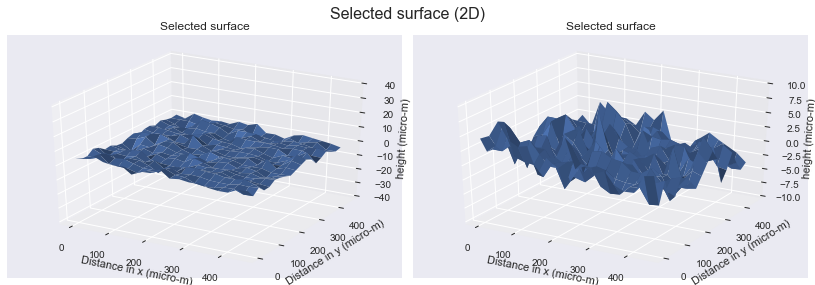

In [141]:
fig = plt.figure(figsize=plt.figaspect(0.35))
fig.suptitle('Selected surface (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')           

X = select_data_list
Y = select_data_list
X, Y = np.meshgrid(X, Y)
Z = df2D_recon_select_pivot

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Selected surface')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d') 

X = select_data_list
Y = select_data_list
X, Y = np.meshgrid(X, Y)
Z = df2D_recon_select_pivot

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Selected surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [142]:
# prepare file name

elemForName = '_' + str(elemsize_select) + 'um'

pntForName = '_' + str(select_data_pnts) + 'pnts'

trimForName = '_trim' + str(trim_min) + '-' + str(trim_max)

selectForName = '_x' + str(x_select) + 'z' + str(z_select)

outputFileName = 'recon2D_' + input_file[:-4] + elemForName + pntForName + trimForName + selectForName + '_waviness'

print(outputFileName)

recon2D_WireCut2_1_450um_19pnts_trim500-1000_x25z25_waviness


In [143]:
# import dataframe to csv (reconstructed surface)

df2D_recon_select.to_csv(outputFileName + '.csv', index=False)